# GPT2 as text classifier

Helpful source: https://drlee.io/fine-tuning-gpt-2-for-sentiment-analysis-94ebdd7b5b24

## Install Required Libraries


In [1]:
!pip install datasets # unified interface for accessing and working with various datasets (by hugging face)
!pip install -U accelerate # library to optimize and accelerate numerical computations
!pip install -U transformers # library by hugging face that gives easy access to pre-trained models, tokenizers, and tools for fine-tuning models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 33.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

## Loading and Processing the Dataset

We load the dataset from Hugging Face. Each sample consists of one strings feature that stores the title as well as the (start of the) article-text. The label is the category that the article belongs to (world, sports, business, sci/tech). [Link](https://huggingface.co/datasets/ag_news/viewer/default/train) to explore the structure of the data.

In [2]:
from datasets import load_dataset

dataset = load_dataset('ag_news')

print(dataset)


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Reduce the size of the dataset (to reduce training times) whilst ensuring that the original structure and distribution of the data is kept.

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd

def take_a_percentage_of_data(dataset, percentage=0.1, shuffle=True, random_state=None):
    # sort and group the dataset by label
    df = pd.DataFrame(dataset)
    df_sorted = df.sort_values(by='label')
    grouped_dfs = df_sorted.groupby('label')

    # ensure that proportions of the groups remains the same as in the original dataset
    filtered_dfs_per_group = []
    for label, group in grouped_dfs:
        num_samples_to_keep = int(len(group) * percentage)
        filtered_group = group.head(num_samples_to_keep)
        filtered_dfs_per_group.append(filtered_group)

    # concatenate (and shuffle) the filtered group-wise dataframes
    filtered_df = pd.concat(filtered_dfs_per_group)
    if shuffle:
        filtered_df = filtered_df.sample(frac=1, random_state=random_state)

    filtered_df.reset_index(drop=True, inplace=True) # resets the index of the DataFrame, drops the previous index column
    filtered_df_as_dict = filtered_df.to_dict(orient='list')
    filtered_dataset = Dataset.from_dict(filtered_df_as_dict)
    return filtered_dataset

dataset_train_1percent = take_a_percentage_of_data(dataset['train'], percentage=0.01)
dataset_test_1percent = take_a_percentage_of_data(dataset['test'], percentage=0.01)

dataset_1percent = DatasetDict({
    'train': dataset_train_1percent,
    'test': dataset_test_1percent
}) # combine the shortened datasets back into the old structure.

print(dataset_1percent)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 76
    })
})


## Tokenizing the dataset

Tokenize the dataset in the exact same way as the GPT-2 model.

In [4]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token # padding tokens added to sequences will be represented by an end-of-sequence token
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length")

tokenized_dataset = dataset_1percent.map(tokenize_function, batched=True) # performed in batches to increase performance

print(tokenized_dataset) # tokenization adds two features: 'input_ids' (the tokenized representation of 'text') as well as 'attention_mask', which ensures that the model does not attend to padding tokens added during tokenization

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 76
    })
})


## Loading the Pre-trained GPT2-Model

Load the pre-trained GPT2-Model for sequence classification.

In [5]:
from transformers import GPT2ForSequenceClassification

gpt2_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=4) # our gpt2-model should distinguish between 4 labels, adds a final fully connected layers with 4 output neurons.

print(gpt2_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=4, bias=False)
)


## Check: Do both models run?

1. The Normal GPT2-Model


In [6]:
import torch

input_ids = torch.randint(0, gpt2_model.config.vocab_size, (1, 512))
labels = torch.tensor([1]).unsqueeze(0)

outputs = gpt2_model(input_ids=input_ids, labels=labels)
loss, logits = outputs['loss'], outputs['logits']
print(f"GPT2 with regular attention mechanism: Loss = {round(loss.item(), 4)}, logits = {logits.detach()}")

GPT2 with regular attention mechanism: Loss = 0.0422, logits = tensor([[-4.5336,  4.3231, -1.4458,  1.1007]])


## Training

Training the GPT2-Model with Gaussian attention

In [7]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    # weight_decay=0.01,
    use_cpu = False,
    no_cuda = False,
    logging_steps = 100,
    save_strategy = "no"
)

trainer = Trainer(
    model=gpt2_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)


In [8]:
model_name = "gpt2-ag_news-1percent"

trainer.train()
trainer.save_model(model_name)
# Save the tokenizer used by the model as well
# tokenizer.save_pretrained(model_name)


Step,Training Loss
100,2.451500
200,1.516300
300,1.155800
400,1.122000
500,0.919400
600,1.185900
700,1.121300
800,0.952300
900,0.758600
1000,0.888900


In [9]:
trainer.evaluate()

{'eval_loss': 0.015347890555858612,
 'eval_runtime': 3.7576,
 'eval_samples_per_second': 20.226,
 'eval_steps_per_second': 20.226,
 'epoch': 5.0}

In [15]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model.to(device)

def predict_label(sentence, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = outputs.logits.argmax(-1).item()

    return prediction

def get_predictions_and_labels(model, data):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for item in data:
            prediction = predict_label(item['text'], model)
            label = item['label']
            predictions.append(prediction)
            labels.append(label)

    return predictions, labels

data = dataset_1percent['test']
predictions, labels = get_predictions_and_labels(gpt2_model, data)

accuracy = np.mean(np.array(predictions) == np.array(labels))
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.9211


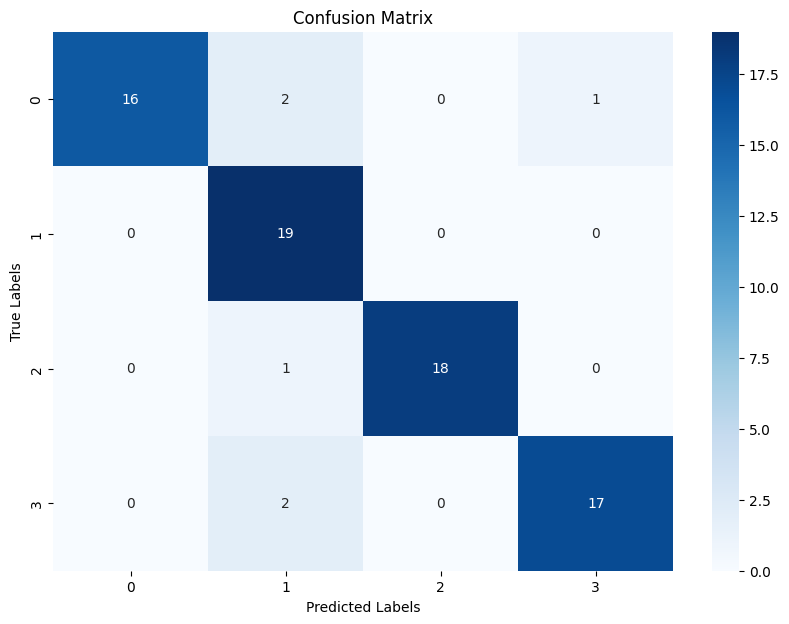

In [16]:
conf_matrix = confusion_matrix(labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()